In [18]:
! pip install langchain-openai
! pip install langchain-community
! pip install -U langchain
! pip install -U langgraph
! pip install langgraph-checkpoint-postgres
! pip install langgraph-checkpoint-sqlite

In [19]:
import os
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display
import gradio as gr
import random
import re
from kaggle_secrets import UserSecretsClient
from dotenv import load_dotenv
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.prebuilt import ToolNode, tools_condition
user_secrets = UserSecretsClient()

secret_value_0 = user_secrets.get_secret("OPENAI_API_KEY")
secret_value_1 = user_secrets.get_secret("PUSHOVER_TOKEN")
secret_value_2 = user_secrets.get_secret("PUSHOVER_USER")
secret_value_3 = user_secrets.get_secret("SERPER_API_KEY")

os.environ["OPENAI_API_KEY"]=secret_value_0
os.environ["PUSHOVER_TOKEN"]=secret_value_1
os.environ["PUSHOVER_USER"]=secret_value_2
os.environ["SERPER_API_KEY"]=secret_value_3

pushover_url = "https://api.pushover.net/1/messages.json"

In [20]:
serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of Bangladesh? write small Note about Bangladesh.")

"Dhaka, city and capital of Bangladesh. It is located just north of the Buriganga River, a channel of the Dhaleswari River, in the south-central part of the country. Dhaka is Bangladesh's most populous city and is one of the largest metropolises in South Asia."

In [21]:
from langchain.tools import tool
import requests


@tool("search", description="Useful for when you need more information from an online search")
def tool_search(query: str) -> str:
    return serper.run(query)

tool_search.invoke("what is the capital of united states")

"Washington, DC, officially the District of Columbia and commonly known as simply Washington or DC, is the capital city and federal district Capital City: Washington, D.C.. Explore the nation's capital as viewed through the collections from the U.S. Capitol to museums and monuments. Prior to establishing the nation's capital in Washington, D.C., the United States Congress and its predecessors met at Independence Hall and Congress Hall in ... Discover why Washington, D.C. is the capital of the United States and explore its historical journey. Initially, the young nation's capital ... The United States Capitol in Washington, D.C., is a symbol of the American people and our government and the meeting place of the nation's legislature, ... Washington D.C. is the capital of the USA. New York city is the financial capital of the USA. New York city is also the most populous city in the USA. Currently ... Washington, D.C., capital of the United States, coextensive with the District of Columbia

In [22]:
def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": secret_value_1, "user": secret_value_2, "message": text})



@tool("send_push_notification", description="Useful for sending a push notification to the user")
def tool_push(text: str) -> str:
    response = requests.post(pushover_url,data={"token": secret_value_1,"user": secret_value_2,"message": text})
    return f"Status: {response.status_code}"


tool_push.invoke("Hi there, It's me")

'Status: 200'

In [23]:
tools = [tool_search, tool_push]

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder=StateGraph(State)



from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",        # Model name
    api_key=secret_value_0,     # Pass your API key directly
    temperature=0.7,            # Controls randomness (0–2)
    max_tokens=1024,            # Max tokens to generate
    top_p=1.0,                  # Nucleus sampling
    frequency_penalty=0.0,      # Penalize new tokens based on frequency
    presence_penalty=0.0,       # Penalize new tokens based on presence
    stop=None,                  # Stop sequences
    stream_usage=False,         # Enable streaming of output
    timeout=60,                 # Request timeout in seconds
    max_retries=3,              # Number of retries if request fails
    reasoning_effort="medium",  # Controls reasoning depth ("low", "medium", "high")
    base_url=None,              # Custom API base URL
    organization=None,          # OpenAI org ID
    model_kwargs={},            # Extra model-specific kwargs
    request_timeout=None,       # Timeout for individual requests
    verbose=True             # Print debug info
)


llm_tools=llm.bind_tools(tools)

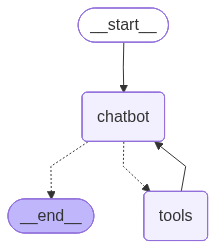

In [24]:
def chatbot(state: State):
    return {"messages": [llm_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")


graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://615b630cf9dc0fedaa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


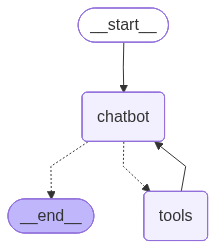

In [26]:
from langgraph.checkpoint.memory import InMemorySaver  
memory = InMemorySaver()
graph_builder = StateGraph(State)
llm_tools=llm.bind_tools(tools)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=secret_value_0,
    temperature=0.7,
    max_tokens=1024,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    stop=None,
    stream_usage=False,
    timeout=60,
    max_retries=3,
    base_url=None,
    organization=None,
    model_kwargs={},  # Keep this empty
    request_timeout=None,
    verbose=True,
    disabled_params={"reasoning_effort": None}  # NEW: Block this param
)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://cb6e5e6de7492d1f84.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


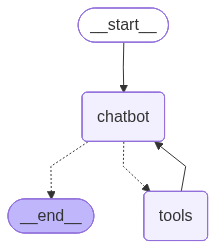

In [35]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

graph_builder = StateGraph(State)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=secret_value_0,
    temperature=0.7,
    max_tokens=1024,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0,
    stop=None,
    stream_usage=False,
    timeout=60,
    max_retries=3,
    base_url=None,
    organization=None,
    model_kwargs={},  # Keep this empty
    request_timeout=None,
    verbose=True,
    disabled_params={"reasoning_effort": None}  # NEW: Block this param
)


llm_tools = llm.bind_tools(tools)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [36]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://7e6ff19bcea877cae8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='ce89f599-23b8-4f6b-83cf-c4872a2b9673'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='eb05883d-1983-4d17-b916-3930d483c395')]}
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='ce89f599-23b8-4f6b-83cf-c4872a2b9673'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='eb05883d-1983-4d17-b916-3930d483c395'), AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 79, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_56